# N-gram Model

### José Pablo Kiesling Lange

In [1]:
import re
from collections import Counter
from collections import defaultdict
import math

import matplotlib.pyplot as plt

import nltk
from nltk import bigrams
from nltk.util import ngrams
from nltk.corpus import cess_esp

In [2]:
nltk.download('cess_esp')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package cess_esp to
[nltk_data]     C:\Users\TheKi\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TheKi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\TheKi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
corpus_nltk = cess_esp.words()

## Estandarización

Para ver la efectivdad de la estandarización, se mostrará las 10 palabras más frecuentes del corpus antes y después de la estandarización. El objetivo es ver si hay modificación en la cantidad de dichas palabras o si una nueva palabra aparece con frecuencia.

In [4]:
def get_most_common_words(corpus, n=10):
    words = [word for line in corpus for word in line.split()]
    most_common = Counter(words).most_common(n)
    return most_common

In [5]:
most_common_words = get_most_common_words(corpus_nltk, n=10)
most_common_words

[(',', 11420),
 ('de', 10234),
 ('la', 6412),
 ('.', 5866),
 ('que', 5552),
 ('el', 5199),
 ('en', 4340),
 ('y', 4235),
 ('*0*', 3883),
 ('"', 3038)]

Además se mostrará los primeros 25 tokens del corpus antes y después de la estandarización.

In [6]:
corpus_nltk[:25]

['El',
 'grupo',
 'estatal',
 'Electricité_de_France',
 '-Fpa-',
 'EDF',
 '-Fpt-',
 'anunció',
 'hoy',
 ',',
 'jueves',
 ',',
 'la',
 'compra',
 'del',
 '51_por_ciento',
 'de',
 'la',
 'empresa',
 'mexicana',
 'Electricidad_Águila_de_Altamira',
 '-Fpa-',
 'EAA',
 '-Fpt-',
 ',']

Como se puede apreciar, hay palabras que tienen `_` en los tokens y separan palabras. Por lo que se harán las funciones específicas para limpiar los tokens y separar las palabras.

In [7]:
def replace_whitespaces(word):
    return "".join(re.sub('_', ' ', word))

In [8]:
def separate_words(word):
    return word.split()

In [9]:
corpus = []

In [10]:
corpus_without_underscore = [replace_whitespaces(word) for word in corpus_nltk]

In [11]:
for word in corpus_without_underscore:
    if len(word.split()) > 1:
        corpus.extend(separate_words(word))
    else:
        corpus.append(word)

Además, se puede ver que hay tokens que empiezan con caracteres no alfanuméricos o que contienen caracteres especiales. Específicamente, los siguientes

In [12]:
list(set(word for word in corpus if not word.isalnum()))[:10]

['km/h',
 '1992/93',
 'm.75',
 '2.133.297',
 '136.400',
 '%',
 'Helms-Burton',
 '3,5',
 '40.000',
 '0,92']

Como se puede ver, hay palabras que tienen `'`o `"` en los tokens por lo que *solo* se eliminarán esos caracteres y no el resto del token. En los otros casos, no representan alguna palabra, por lo que se eliminarán completamente.

In [13]:
def clean_word(word):
    if re.search(r'[^a-zA-Z0-9\'"áéíóúÁÉÍÓÚ]', word):
        return ""
    
    return re.sub(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚ]', '', word)

In [14]:
corpus = [clean_word(word) for word in corpus]

In [15]:
corpus = [word for word in corpus if clean_word(word) != '']

Finalmente, se pondrán las palabras en minúsculas solo si no es sigla o acrónimo. Para esto, se hará una función que verifique si la palabra está en mayúsculas y si no es así, la pondrá en minúsculas.

In [16]:
def case_folding(corpus):
    return [word.lower() if not word.isupper() else word for word in corpus]

In [17]:
corpus = case_folding(corpus)

In [18]:
most_common_words = get_most_common_words(corpus, n=10)
most_common_words

[('de', 11828),
 ('la', 7150),
 ('el', 6079),
 ('que', 5943),
 ('en', 4991),
 ('y', 4318),
 ('a', 3493),
 ('los', 3229),
 ('del', 2514),
 ('las', 1956)]

In [19]:
corpus[:25]

['el',
 'grupo',
 'estatal',
 'electricité',
 'de',
 'france',
 'EDF',
 'anunció',
 'hoy',
 'jueves',
 'la',
 'compra',
 'del',
 '51',
 'por',
 'ciento',
 'de',
 'la',
 'empresa',
 'mexicana',
 'electricidad',
 'águila',
 'de',
 'altamira',
 'EAA']

Como se puede apreciar, ya solo hay palabras alfanuméricas y con acentos. Y todas están separadas como se debe

## Model 2-gram based

La implementación del modelo se hizo en base a la implementación de [geeksforgeeks](https://www.geeksforgeeks.org/nlp/n-gram-language-modelling-with-nltk/).

In [20]:
words = nltk.word_tokenize(' '.join(corpus), language='spanish')

In [21]:
def get_bigrams(tokens):
    bigrams = defaultdict(Counter)
    
    for i, token in enumerate(tokens[:-1]):
        w1 = token
        w2 = tokens[i + 1]
        bigrams[w1][w2] += 1

    return bigrams

In [22]:
def get_ngram_probabilities(bigrams):
    probabilities = defaultdict(dict)
    
    for w1, w2_counts in bigrams.items():
        total_count = sum(w2_counts.values())
        for w2, count in w2_counts.items():
            probabilities[w1][w2] = count / total_count

    return probabilities

In [23]:
bigram = get_bigrams(words)
bigram_probabilities = get_ngram_probabilities(bigram)

In [24]:
bigram_probabilities['de']['la']

0.1439803855258708

la probabilidad de que la palabra `la` (segunda más frecuente en el corpus) siga a la palabra `de` (la más frecuente en el corpus) es de 0.14

In [25]:
def predict_next_words(w1, length, model):
    prediction = [w1]

    for _ in range(length):
        w1 = prediction[-1]
        if w1 in model and model[w1]:
            w2 = max(model[w1], key=model[w1].get)
        prediction.append(w2)

    return prediction


In [26]:
predict_next_words('francia', 5, bigram_probabilities)

['francia', 'y', 'el', 'que', 'se', 'ha']

## Preplejidad

In [27]:
sentence = 'la potencia del gas natural es muy importante para el desarrollo sostenible'

In [28]:
def calculate_perplexity(sentence, probabilities):
    perplexity = float('inf')
    
    words = nltk.word_tokenize(sentence, language='spanish')
    model_ngrams = list(bigrams(words))
    log_prob_sum = 0.0
    for w1, w2 in model_ngrams:
        prob = probabilities.get(w1, {}).get(w2, 1e-5)
        log_prob_sum += math.log(prob)
        
    perplexity = math.exp(-log_prob_sum / len(model_ngrams))
        
    return perplexity

In [29]:
calculate_perplexity(sentence, bigram_probabilities)

260.53543348194887

## Corpus length variation

In [30]:
def get_corpus_length_variation(tokens, percentage):
    length = int(percentage * len(tokens))
    return corpus[:length]

In [31]:
sizes = [0.01, 0.05, 0.1, 0.5, 1.0]

In [32]:
perplexities = []

In [33]:
for size in sizes:
    sample_size = int(len(words) * size)
    sample_tokens = words[:sample_size]
    sample_bigrams = get_bigrams(sample_tokens)
    sample_bigram_probs = get_ngram_probabilities(sample_bigrams)

    perplexities.append(calculate_perplexity(sentence, sample_bigram_probs))

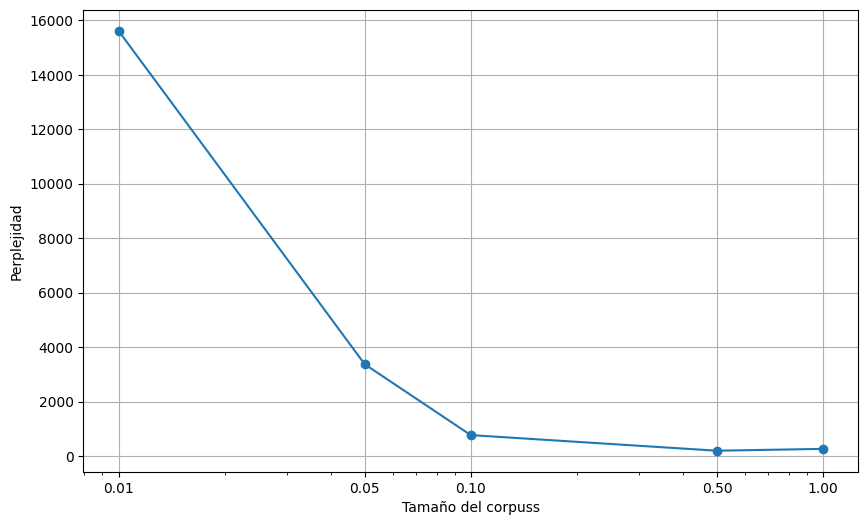

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, perplexities, marker='o')
plt.xscale('log')
plt.xlabel('Tamaño del corpuss')
plt.ylabel('Perplejidad')
plt.grid(True)
plt.xticks(sizes, [f"{s:.2f}" for s in sizes])
plt.show()

## N-gram

In [35]:
def get_ngrams(tokens, n):
    ngrams = defaultdict(Counter)
    
    for i in range(len(tokens) - n + 1):
        context = tuple(tokens[i:i + n - 1])
        next_word = tokens[i + n - 1]
        ngrams[context][next_word] += 1
        
    return ngrams

In [36]:
def ngram_probabilities(ngrams):
    probabilities = defaultdict(dict)
    
    for context, next_words in ngrams.items():
        total_count = sum(next_words.values())
        for word, count in next_words.items():
            probabilities[context][word] = count / total_count
            
    return probabilities

In [37]:
def get_ngram_prob(context, word, probabilities):
    probability = 1e-6
    if context in probabilities and word in probabilities[context]:
        probability = probabilities[context][word]
    
    return probability

In [38]:
def ngram_perplexity(sentence, n, probabilities):
    perplexity = float('inf')
    
    words = nltk.word_tokenize(sentence, language='spanish')

    ngrams_test = list(nltk.ngrams(words, n))
    log_prob_sum = 0
    for ng in ngrams_test:
        context = tuple(ng[:-1])
        next_word = ng[-1]
        prob = get_ngram_prob(context, next_word, probabilities)
        log_prob_sum += math.log(prob)
        
    perplexity = math.exp(-log_prob_sum / len(ngrams_test))   
    
    return perplexity

In [39]:
models_size = [2, 3, 4, 5]

In [40]:
models = {}

In [41]:
for n in models_size:
    ngram_counts = get_ngrams(words, n)
    probabilities = ngram_probabilities(ngram_counts)
    models[n] = probabilities

In [42]:
perplexities_by_ngram = {}

In [43]:
for n in models_size:
    current_perplexities = []
    for size in sizes:
        sample_size = int(len(words) * size)
        sample_tokens = words[:sample_size]
        sample_ngrams = get_ngrams(sample_tokens, n)
        sample_ngram_probs = ngram_probabilities(sample_ngrams)

        current_perplexities.append(ngram_perplexity(sentence, n, sample_ngram_probs))
    
    perplexities_by_ngram[n] = current_perplexities

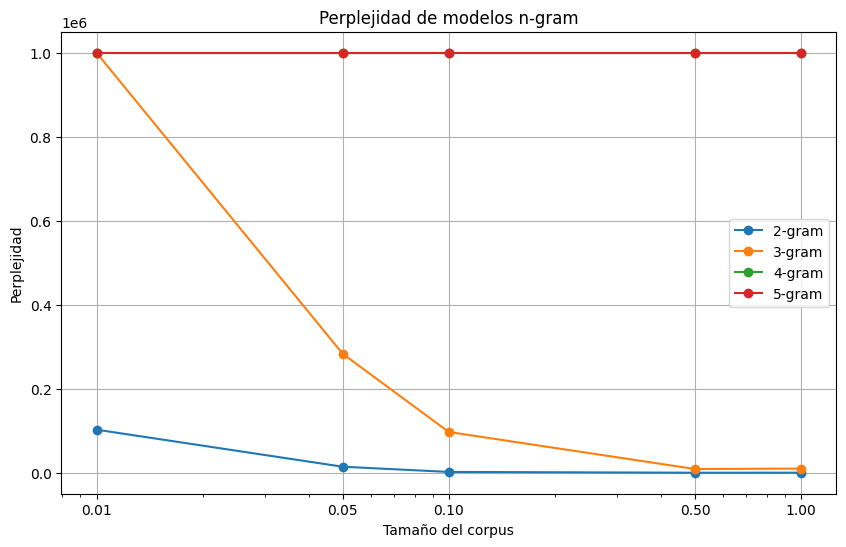

In [44]:
plt.figure(figsize=(10, 6))

for n in models_size:
    plt.plot(sizes, perplexities_by_ngram[n], marker='o', label=f'{n}-gram')

plt.xscale('log')
plt.xlabel('Tamaño del corpus')
plt.ylabel('Perplejidad')
plt.grid(True)
plt.xticks(sizes, [f"{s:.2f}" for s in sizes])
plt.title('Perplejidad de modelos n-gram')
plt.legend()
plt.show()


In [45]:
for n in models:
    perp = ngram_perplexity(sentence, n, models[n])
    print(f"Perplejidad para {n}-gramas: {perp:.2f}")

Perplejidad para 2-gramas: 395.99
Perplejidad para 3-gramas: 10104.22
Perplejidad para 4-gramas: 1000000.00
Perplejidad para 5-gramas: 1000000.00
